crowdedness at campus gym dataset from kaggle.com
from dataset overview, count of people was taken every 10 minutes during a school year

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('C:\\Data') #I like to keep data files in one place

In [2]:
gym = pd.read_csv('crowdedness-at-the-campus-gym.csv')
print(gym.describe())
print(gym.info())

       number_people     timestamp   day_of_week    is_weekend    is_holiday  \
count   62184.000000  62184.000000  62184.000000  62184.000000  62184.000000   
mean       29.072543  45799.437958      2.982504      0.282870      0.002573   
std        22.689026  24211.275891      1.996825      0.450398      0.050660   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         9.000000  26624.000000      1.000000      0.000000      0.000000   
50%        28.000000  46522.500000      3.000000      0.000000      0.000000   
75%        43.000000  66612.000000      5.000000      1.000000      0.000000   
max       145.000000  86399.000000      6.000000      1.000000      1.000000   

        temperature  is_start_of_semester  is_during_semester         month  \
count  62184.000000          62184.000000        62184.000000  62184.000000   
mean      58.557108              0.078831            0.660218      7.439824   
std        6.316396              0.269476 

Let's clean up a few things and add descriptions

In [3]:
gym['date'] = pd.to_datetime(gym['date'])
print('Date range of measurements: ' + str(min(gym.date)) + ' to ' + str(min(gym.date)))

def label_days(row): 
    #Map day index to day description for visualization
    #From the dataset overview, day_of_week=0 means Monday ... day_of_week=6 means Sunday
    if row['day_of_week'] == 0:
        return 'Mon'
    elif row['day_of_week'] == 1:
        return 'Tues'
    elif row['day_of_week'] == 2:
        return 'Weds'
    elif row['day_of_week'] == 3:
        return 'Thurs'
    elif row['day_of_week'] == 4:
        return 'Fri'
    elif row['day_of_week'] == 5:
        return 'Sat'
    elif row['day_of_week'] == 6:
        return 'Sun'

gym['day_of_week_desc'] = gym.apply(label_days,axis=1)
gym['day_of_month'] = gym.date.dt.day

Date range of measurements: 2015-08-15 00:00:11 to 2015-08-15 00:00:11


Are there days that more people go to the gym? 

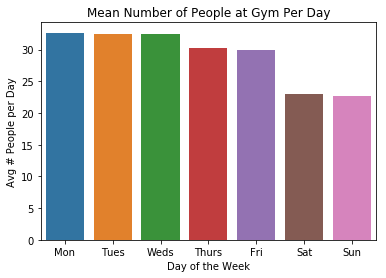

In [4]:
gymDOW = gym.groupby(['day_of_week_desc'], as_index=False).mean()

#plt.subplot(2, 1, 1) #More plots to come
sns.barplot(x='day_of_week_desc', y='number_people',
            data=gymDOW, order=['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'])
plt.title('Mean Number of People at Gym Per Day')
plt.xlabel('Day of the Week')
plt.ylabel('Avg # People per Day')
plt.show()

Looks like people the weekend tends to be less crowded.

Does the temperature have much of an impact on gym attendance? Let's take a look at the first month of each quarter in 2016, since we have a that full year of data.

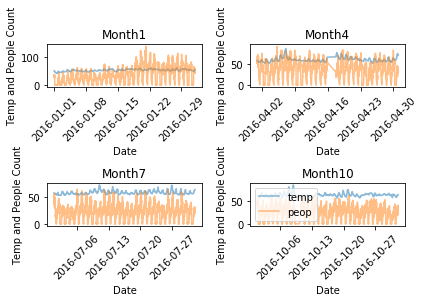

In [5]:
plotSpot = [1,2,3,4]
qtrBegin = [1,4,7,10]
for i in range(0,4):
    plt.subplot(2, 2, plotSpot[i])
    x = gym.loc[(gym.date.dt.year == 2016) & (gym.date.dt.month == qtrBegin[i]), 'date']
    yTemp = gym.loc[(gym.date.dt.year == 2016) & (gym.date.dt.month == qtrBegin[i]), 'temperature']
    yPeop = gym.loc[(gym.date.dt.year == 2016) & (gym.date.dt.month == qtrBegin[i]), 'number_people']
    sns.lineplot(x=x,y=yTemp, alpha=0.5)
    sns.lineplot(x=x,y=yPeop, alpha=0.5)
    plt.ylabel('Temp and People Count')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.title('Month' + str(qtrBegin[i]))
    
plt.legend(['temp', 'peop'], loc=3)
plt.tight_layout()
plt.show()

These plots look pretty busy, but we can see a few trends. Temperature tends to be lower in January and there looks like there is an increase in gym attendance during the second half of the month. That seems typical of New Year's resolutions and students coming back to campus after winter break. Attendance seems higher in the beginning of the year from what we can see in January and April.

Are there specific hours where the gym is less crowded? (We can kind of see this in the above graphs, I'm guessing the lower portions of the oscillating "People Count" is night time. Let's see. 

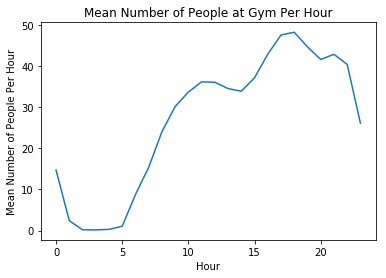

In [6]:
gymHour = gym.groupby(['hour'], as_index=False).mean()

sns.lineplot(x=gymHour['hour'],y=gymHour['number_people'])
plt.xlabel('Hour')
plt.ylabel('Mean Number of People Per Hour')
plt.title('Mean Number of People at Gym Per Hour')
plt.show()

As expected, average gym attendance drops at night. This shows the daily oscillation from the previous graphs. Between 10PM and 5AM, the gym is empty. The average number of people is never zero, so I assume it was open 24 hours, just not very active  at night time. I'm not sure which campus or gym this data was collected from. 

Now, let's perform principal component analysis to see which features provide the most insight. The idea is to remove features that don't give us much more information than we need. This helps machine learning algorithms run faster since we'll be using less data, but not at a significant cost to the algorithm's learning potential. We'll run a PCA model and view the variance of each feature and the higher the variance, the more informative that feature will be to a machine learning algorithm which we'll want to keep in the analysis.

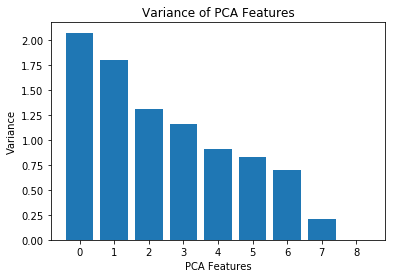

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA()

features = gym.loc[:,'timestamp':'hour']

scaledFeatures = scaler.fit_transform(features)
pca.fit(scaledFeatures)
featureRange = range(pca.n_components_)
plt.bar(featureRange, pca.explained_variance_)
plt.xticks(featureRange)
plt.xlabel('PCA Features')
plt.ylabel('Variance')
plt.title('Variance of PCA Features')
plt.show()

This is a judgement call on how many features to proceed with. Features 0 through 6 (inclusive) have significant variance. The seventh and eighth features have little to no variance, so I'll say it's safe to move forward without them. 

In [13]:
pca = PCA(n_components=7)
pcaFeatures = pca.fit_transform(features)
print(pcaFeatures.shape)

(62184, 7)

Let's run a linear regressor and a descision tree regressor against the entire dataset and then run them againt the dataset post PCA to see the effect on the algorithm's performance. "Score" refers to R^2 in this case.

In [32]:
#Full dataset
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

labels = gym.loc[:,'number_people']

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=261)

regLM = LinearRegression()
regLM.fit(X_train, y_train)
print('Linear Regression score with full dataset: ' + str(regLM.score(X_test, y_test)))

regTree = DecisionTreeRegressor()
regTree.fit(X_train, y_train)
print('Decision Tree Regressor score with full dataset: ' + str(regTree.score(X_test, y_test)))

Linear Regression score with full dataset: 0.5078798347470452
Decision Tree Regressor score with full dataset: 0.8516410147239768


In [33]:
#PCA dataset
labels = gym.loc[:,'number_people']

X_train, X_test, y_train, y_test = train_test_split(pcaFeatures, labels, random_state=261)

regLM = LinearRegression()
regLM.fit(X_train, y_train)
print('Linear Regression score with dataset post PCA: ' + str(regLM.score(X_test, y_test)))

regTree = DecisionTreeRegressor()
regTree.fit(X_train, y_train)
print('Decision Tree Regressor score with dataset post PCA: ' + str(regTree.score(X_test, y_test)))

Linear Regression score with dataset post PCA: 0.5042847687957712
Decision Tree Regressor score with dataset post PCA: 0.778877945827547


The scores are lower using the PCA datasets, but r^2 values are very similar for the linear regression run on the full dataset versus the PCA dataset. The decision tree score decreased significantly. We should visualize the results for a better understanding...